<a href="https://colab.research.google.com/github/prp20/PytorchLearning/blob/main/Pnemonia_detection_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [01:50<00:00, 39.3MB/s]
100% 3.66G/3.66G [01:50<00:00, 35.6MB/s]


In [ ]:
!unzip /content/rsna-pneumonia-detection-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

## Introduction
In this notebook we will preprocess the data for our classification task.<br />
We will train a classifier to predict whether an X-Ray of a patient shows signs of pneumonia or not based on the RSNA Pneumonia Detection Challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge).

At first we download the data from kaggle (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data), by clicking on "Download All" and extract it afterwards.

Acknowledgements:
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

Original Source: https://nihcc.app.box.com/v/ChestXray-NIHCC

## Imports
* pathlib for convenient path handling
* pydicom for reading dicom files
* numpy for storing the actual images
* cv2 for directly resizing the images
* pandas to read the provided labels
* matplotlib for visualizing some images
* tqdm for nice progress bar

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.9 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

At first, we read the csv file containing the labels

In [ ]:
labels = pd.read_csv("/content/stage_2_train_labels.csv")

In [ ]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Note that subjects may occur multiple times in the dataset because different pneumonia spots are handled indivually. For our classification task, we can remove those duplicates as we are only interested in the binary label.

In [ ]:
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")

In [ ]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Let's define the path to the dicom files and also the path were we want to store our processed npy files

In [ ]:
ROOT_PATH = Path("/content/stage_2_train_images")
SAVE_PATH = Path("Processed/")

Let's look at some example images

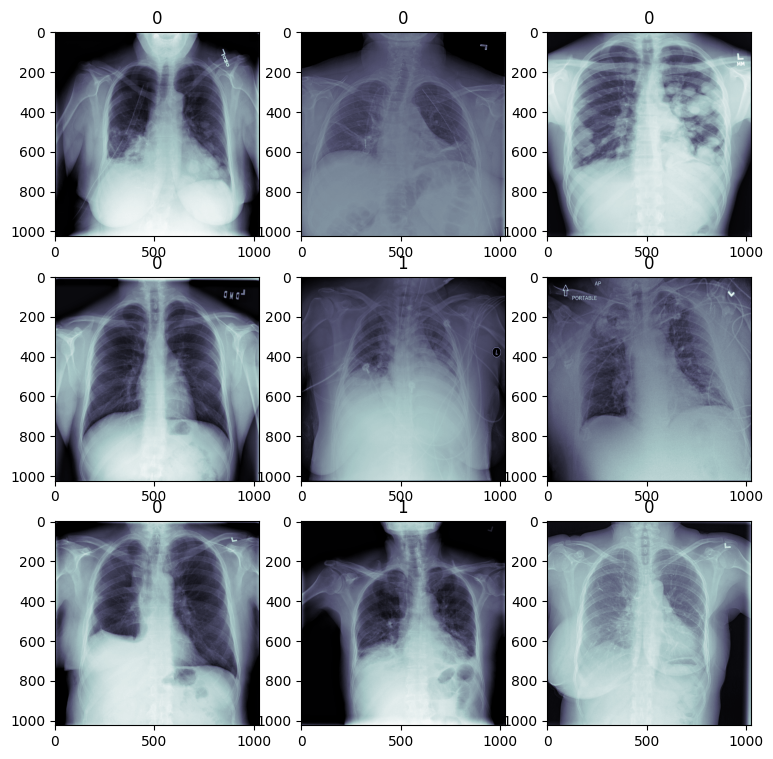

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array

        label = labels["Target"].iloc[c]

        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

## Dicom Reading & Effective storage

In order to efficiently handle our data in the Dataloader, we convert the X-Ray images stored in the DICOM format to numpy arrays. Afterwards we compute the overall mean and standard deviation of the pixels of the whole dataset, for the purpose of normalization.
Then the created numpy images are stored in two separate folders according to their binary label:
* 0: All X-Rays which do not show signs of pneumonia
* 1: All X-Rays which show signs of pneumonia

To do so, we iterate over the patient ids and concat the patient ID with the ROOT_PATH.

We then directly save the standardized and resized files into the corresponding directory (0 for healthy, 1 for pneumonia).
This allows to take advantage of the ready-to-use torchvision **DatasetFolder** for simple file reading


We standardize all images by the maximum pixel value in the provided dataset, 255.
All images are resized to 224x224.

To compute dataset mean and standard deviation, we compute the sum of the pixel values as well as the sum of the squared pixel values for each subject.
This allows to compute the overall mean and standard deviation without keeping the whole dataset in memory.


In [ ]:
sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix

    # Read the dicom file with pydicom and standardize the array
    dcm = pydicom.read_file(dcm_path).pixel_array / 255

    # Resize the image as 1024x1024 is way to large to be handeled by Deep Learning models at the moment
    # Let's use a shape of 224x224
    # In order to use less space when storing the image we convert it to float16
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

    # Retrieve the corresponding label
    label = labels.Target.iloc[c]

    # 4/5 train split, 1/5 val split
    train_or_val = "train" if c < 24000 else "val"

    current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory

    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
    if train_or_val == "train":  # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer


  0%|          | 0/26684 [00:00<?, ?it/s]

In [ ]:
mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))

We will use mean and std later in the dataloader to normalize our data

In [ ]:
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.4903962485384803, STD: 0.24795070634161256


In [ ]:
!pip install torchmetrics lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 31.7 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale = (0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1), antialias=True)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
train_dataset = torchvision.datasets.DatasetFolder("Processed/train", loader=load_file, extensions="npy", transform = train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("Processed/val", loader=load_file, extensions="npy", transform = val_transforms)

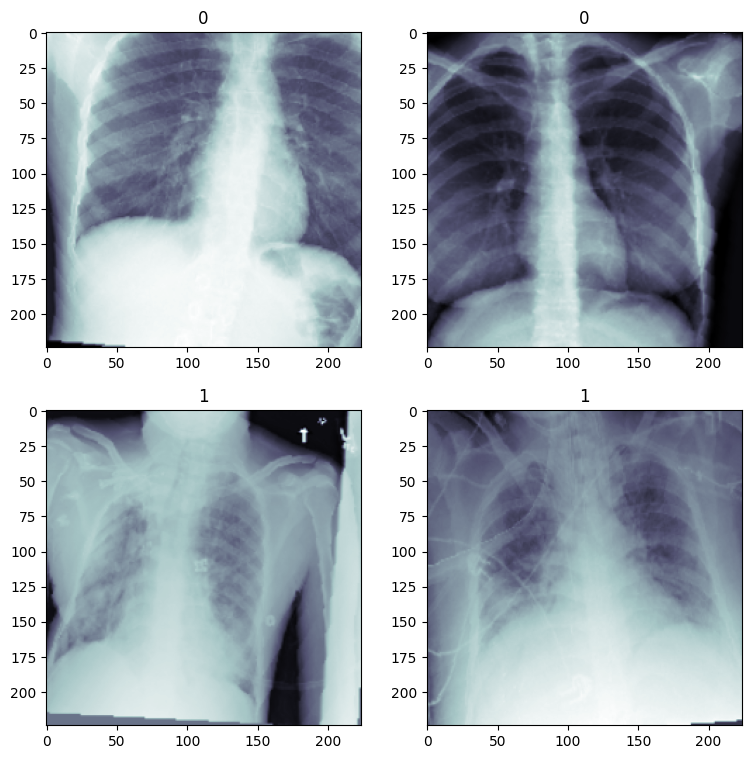

In [ ]:
fig, axis = plt.subplots(2,2, figsize=(9,9))
for i in range(2):
  for j in range(2):
    random_index = np.random.randint(0,24000)
    x_ray, label = train_dataset[random_index]
    axis[i][j].imshow(x_ray[0], cmap="bone")
    axis[i][j].set_title(label)


In [ ]:
batch_size=32
num_workers = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

In [ ]:
class PneumonialModel(pl.LightningModule):
  def __init__(self, weight=1):
    super().__init__()
    self.model = torchvision.models.resnet18()
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([3]))
    self.train_acc = torchmetrics.Accuracy(task='binary', num_classes=2)
    self.val_acc = torchmetrics.Accuracy(task='binary', num_classes=2)

  def forward(self, data):
    pred = self.model(data)
    return pred

  def training_step(self, batch, batch_idx):
    x_ray, label = batch
    label = label.float()
    pred = self(x_ray)[:, 0]
    loss = self.loss_fn(pred, label)
    self.log("Train Loss", loss)
    self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))

    return loss

  def on_train_epoch_end(self):
    self.log("Train Acc", self.train_acc.compute())

  def validation_step(self, batch, batch_idx):
    x_ray, label = batch
    label = label.float()
    pred = self(x_ray)[:, 0]
    loss = self.loss_fn(pred, label)
    self.log("Val Loss", loss)
    self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))

  def on_validation_epoch_end(self):
    self.log("Val ACC", self.val_acc.compute())

  def configure_optimizers(self):
    return [self.optimizer]

In [ ]:
model = PneumonialModel()

checkpoint_callback = ModelCheckpoint(monitor="Val ACC",
                                      dirpath='/content/',
                                      filename='rsna-pneumonia-detection-model',
                                      save_top_k=10,
                                      mode="max")


In [ ]:
gpus = 1 #TODO
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = PneumonialModel.load_from_checkpoint("/content/logs/lightning_logs/version_0/checkpoints/epoch=25-step=19500.ckpt")

In [ ]:
model.eval()

PneumonialModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
model.to(device)

PneumonialModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
preds = []
labels = []

with torch.no_grad():
  for data, label in tqdm(val_dataset):
    data = data.to(device).float().unsqueeze(0)
    pred = torch.sigmoid(model(data)[0].cpu())
    preds.append(pred)
    labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [ ]:
acc = torchmetrics.Accuracy(task="binary", num_classes=2)(preds, labels)
precision = torchmetrics.Precision(task="binary", num_classes=2)(preds, labels)
recall = torchmetrics.Recall(task="binary", num_classes=2)(preds, labels)
conf_mat = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")

Val Accuracy: 0.8099851012229919
Val Precision: 0.5554258823394775
Val Recall: 0.7867768406867981


In [ ]:
conf_mat

tensor([[1698,  381],
        [ 129,  476]])

## Interpreting the Data obtained

In [ ]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [ ]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class PneumonialModelUpdated(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = torchvision.models.resnet18()
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
    self.model.fc = torch.nn.Linear(in_features = 512, out_features = 1)
    self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])

  def forward(self, data):
    feature_map = self.feature_map(data)
    avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1,1))
    avg_output_flattened = torch.flatten(avg_pool_output)
    pred = self.model.fc(avg_output_flattened)
    return pred, feature_map

In [ ]:
model_new = PneumonialModelUpdated.load_from_checkpoint("/content/logs/lightning_logs/version_0/checkpoints/epoch=25-step=19500.ckpt", strict=False)
model_new.to(device)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:173: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map.5.0.conv1.weight', 'feature_map.5.0.bn1.weight', 'feature_map.5.

PneumonialModelUpdated(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
model_new.eval()

PneumonialModelUpdated(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
def cam(model, img):
    """
    Compute class activation map according to cam algorithm
    """
    img = img.to(device)
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    b, c, h, w = features.shape

    # We reshape the 512x7x7 feature tensor into a 512x49 tensor in order to simplify the multiplication
    features = features.reshape((c, h*w))

    # Get only the weights, not the bias
    weight_params = list(model.model.fc.parameters())[0]

    # Remove gradient information from weight parameters to enable numpy conversion
    weight = weight_params[0].detach()
    print(weight.shape)
    # Compute multiplication between weight and features with the formula from above.
    # We use matmul because it directly multiplies each filter with the weights
    # and then computes the sum. This yields a vector of 49 (7x7 elements)
    cam = torch.matmul(weight, features)
    print(features.shape)

    ### The following loop performs the same operations in a less optimized way
    #cam = torch.zeros((7 * 7))
    #for i in range(len(cam)):
    #    cam[i] = torch.sum(weight*features[:,i])
    ##################################################################

    # Normalize and standardize the class activation map (Not always necessary, thus not shown in the lecture)
    cam = cam - torch.min(cam)
    cam_img = cam / torch.max(cam)
    # Reshape the class activation map to 512x7x7 and move the tensor back to CPU
    cam_img = cam_img.reshape(h, w).cpu()

    return cam_img, torch.sigmoid(pred)

In [ ]:
def visualize(img, cam, pred):
  img = img[0]
  cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
  fig, axis = plt.subplots(1,2)
  axis[0].imshow(img, cmap="bone")
  axis[1].imshow(cam, alpha=0.5, cmap="jet")
  plt.title(pred > 0.5 )

torch.Size([512])
torch.Size([512, 49])


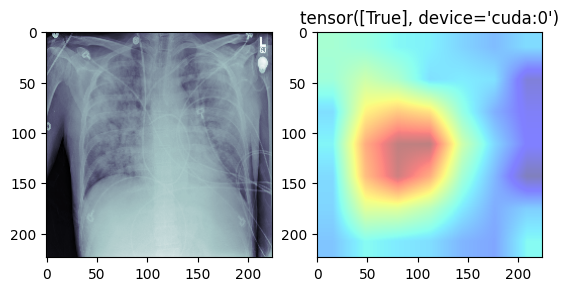

In [ ]:
img = val_dataset[-20][0]
activation_map, pred = cam(model_new, img)
visualize(img, activation_map, pred)